In [1]:
import sys
import os
sys.path.insert(0,'../classes')
sys.path.insert(0,'../analysis')
import anl

sys.path.insert(0,'/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new')
hqfd = '/home/zz737/projects/fiar/cog_model/fourinarow/Analysis notebooks/new/Heuristic quality'
sys.path.insert(0,hqfd)
from fourinarowfunctions import *
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import logging
import numpy as np

import coloredlogs

from arena import Arena
from coach import Coach
from beck.beck_game import BeckGame as Game
from beck.beck_nnet import NNetWrapper as nn
from beck.beck_players import HumanBeckPlayer
from mcts import MCTS
from utils import *
log = logging.getLogger(__name__)

from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import initializers
from keras import regularizers
import keras
import tensorflow as tf


import tournament
# participant_iters = tournament.participant_iters

participants_dir = '/scratch/zz737/fiar/tournaments/tournament_4' # dir for trained networks
results_dir = '/scratch/zz737/fiar/tournaments/results/tournament_4'
moves_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/raw/'
splits_dir = '/scratch/zz737/fiar/tournaments/tournament_4/moves/splits/'

import load
import plot_fun
from importlib import reload
reload(load)

import value_analysis as va
import pandas as pd
import create_database as cd
all_players = pd.read_pickle(cd.DATABASE_LOC)

game = Game(4,9,4)

{'mcts100_cpuct1': [1, 2, 3, 4, 6, 7, 9, 11, 12, 16, 18, 21, 25, 28, 29, 30, 37, 38, 39, 45, 47], 'mcts100_cpuct2': [1, 2, 3, 4, 6, 8, 12, 14, 15, 16, 21, 22, 24, 26, 27, 30, 32, 35, 39], 'mcts100_cpuct3': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 16, 17, 18, 20, 21, 25, 26, 28, 32, 34, 35, 36], 'mcts25_cpuct1': [1, 2, 3, 4, 9, 11, 13, 14, 16, 19, 22, 25, 28, 29, 31, 37, 39, 45, 59, 61], 'mcts50_cpuct1': [1, 2, 3, 4, 5, 6, 7, 9, 10, 13, 17, 18, 20, 21, 23, 25, 28, 29, 31, 37, 39, 41, 44, 45, 47, 48, 53], 'mcts80_cpuct1': [1, 2, 3, 4, 5, 7, 8, 9, 10, 13, 16, 19, 20, 21, 23, 24, 28, 34, 35, 36, 40], 'mcts80_cpuct2': [1, 2, 5, 6, 8, 10, 12, 13, 15, 17, 18, 19, 22, 25, 28, 30, 31, 34, 37, 38, 39, 40, 43, 45, 46, 51], 'mcts80_cpuct3': [1, 2, 5, 6, 7, 9, 12, 13, 14, 19, 21, 22, 23, 24, 26, 27, 28, 35, 36, 42, 43, 47, 49, 50, 51, 53, 54, 55, 56, 57]}
189 participant iterations!


In [6]:
import tournament_new as tn
game = Game(4,9,4)
one_info = all_players.loc[all_players['id']=='tournament_5;mcts100;cpuct2;id-1;best'].iloc[0]
ai,val_func,tree = tn.get_player(game, one_info)

In [3]:
opt_boards, opt_values=va.load_opt_value_test_boards()

In [45]:
class FeatureNet():
    def __init__(self,game,**kwargs):
        
        self.board_x, self.board_y = game.getBoardSize()
        self.input_boards = Input(shape=(self.board_x, self.board_y))
        x_image = Reshape((self.board_x, self.board_y, 1))(self.input_boards)
        
        h_conv = Conv2D(kwargs['num_channels'],4,activation='relu',padding='same',strides=1,use_bias=False,kernel_regularizer='l1_l2')(x_image)
        feat_counts = GlobalAveragePooling2D()(h_conv)
        feat_counts_flatten = Flatten()(feat_counts)
        self.v = Dense(1,activation='tanh',name='v')(feat_counts_flatten)
        self.model = Model(inputs=self.input_boards, outputs=self.v)
        self.model.compile(loss='mean_squared_error',optimizer=Adam(kwargs['lr'],kwargs['decay']))
        
        
        

In [51]:
featnet = FeatureNet(game,num_channels=100,lr=0.05,decay=0)

In [29]:
all_vals = val_func.predict_batch(opt_boards)

In [30]:
all_vals = all_vals[1]

In [ ]:
featnet.model.fit(x = opt_boards[:8000],y = all_vals[:8000], batch_size=64, epochs=100)

Epoch 1/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6550
Epoch 2/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6532
Epoch 3/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6534
Epoch 4/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6618
Epoch 5/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6568
Epoch 6/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6630
Epoch 7/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6792
Epoch 8/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6526
Epoch 9/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6560
Epoch 10/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6544
Epoch 11/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6590
Epoch 12/100
86/86 [==============================] - 0s 1ms/step - loss: 0.6628
Epoch 13/100
86/86 [=================

In [48]:
kk=6
print(featnet.model(opt_boards[kk][None,...]))
print(all_vals[kk])


tf.Tensor([[-0.26257762]], shape=(1, 1), dtype=float32)
[0.99997854]


In [49]:
allpreds = featnet.model(opt_boards).numpy()


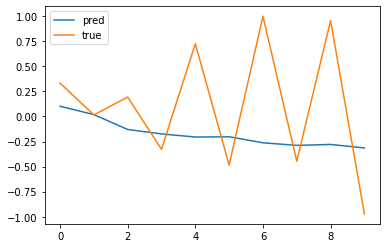

In [50]:
ks = 0
ke=10
plt.plot(allpreds[ks:ke])
plt.plot(all_vals[ks:ke])
plt.legend(['pred','true'])